In [1]:
!pip install geemap

import ee
import geemap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.2 MB/s eta 0:00:00


In [2]:
ee.Authenticate()
ee.Initialize(project="ndvi-trend-481019")

In [3]:
# roi = ee.Geometry.Rectangle([82.5, 22.6, 83.2, 23.2])
# roi = ee.Geometry.Rectangle([82.35, 22.70, 83.05, 23.00])
roi = ee.Geometry.BBox(82.58, 22.4, 83.20, 22.90)

Map = geemap.Map()
Map.centerObject(roi, 9)

Map.addLayer(roi, {}, "ROI")
# Map


In [4]:
area = roi.area(maxError=1)
print("ROI Area (sq km):", area.divide(1e6).getInfo())

ROI Area (sq km): 3537.316319013448


In [5]:
collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate('2018-01-01', '2025-12-31')
)

print("Total raw images:", collection.size().getInfo())


Total raw images: 2184


In [6]:
year = 2018
start_date = ee.Date.fromYMD(year, 1, 1)

for i in range(26):
    window_start = start_date.advance(i * 14, 'day')
    window_end = window_start.advance(14, 'day')

    count = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate(window_start, window_end)
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60))
        .size()
        .getInfo()
    )

    print(f"Window {i+1}: {window_start.format('YYYY-MM-dd').getInfo()} → Images:", count)


Window 1: 2018-01-01 → Images: 7
Window 2: 2018-01-15 → Images: 5
Window 3: 2018-01-29 → Images: 3
Window 4: 2018-02-12 → Images: 3
Window 5: 2018-02-26 → Images: 4
Window 6: 2018-03-12 → Images: 2
Window 7: 2018-03-26 → Images: 2
Window 8: 2018-04-09 → Images: 3
Window 9: 2018-04-23 → Images: 0
Window 10: 2018-05-07 → Images: 0
Window 11: 2018-05-21 → Images: 0
Window 12: 2018-06-04 → Images: 0
Window 13: 2018-06-18 → Images: 0
Window 14: 2018-07-02 → Images: 0
Window 15: 2018-07-16 → Images: 0
Window 16: 2018-07-30 → Images: 0
Window 17: 2018-08-13 → Images: 0
Window 18: 2018-08-27 → Images: 0
Window 19: 2018-09-10 → Images: 0
Window 20: 2018-09-24 → Images: 0
Window 21: 2018-10-08 → Images: 0
Window 22: 2018-10-22 → Images: 1
Window 23: 2018-11-05 → Images: 8
Window 24: 2018-11-19 → Images: 3
Window 25: 2018-12-03 → Images: 2
Window 26: 2018-12-17 → Images: 8


In [21]:
def check_month(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')

    collection = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate(start, end)
    )

    return collection.size().getInfo()

for m in range(1,13):
    print("Month", m, "Images:", check_month(2018, m))


Month 1 Images: 15
Month 2 Images: 3
Month 3 Images: 8
Month 4 Images: 3
Month 5 Images: 0
Month 6 Images: 3
Month 7 Images: 0
Month 8 Images: 0
Month 9 Images: 0
Month 10 Images: 1
Month 11 Images: 11
Month 12 Images: 14


In [22]:
def mask_s2_clouds(image):
    scl = image.select('SCL')

    # Keep only good pixels:
    mask = (
        scl.eq(4)   # vegetation
        .Or(scl.eq(5))   # bare soil
        .Or(scl.eq(6))   # water
        .Or(scl.eq(7))   # unclassified
    )

    return image.updateMask(mask)

# def get_monthly_composite(year, month):

#     start = ee.Date.fromYMD(year, month, 1)
#     end = start.advance(1, 'month')

#     image = (
#         ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
#         .filterBounds(roi)
#         .filterDate(start, end)
#         .map(mask_s2_clouds)
#         .median()
#         .clip(roi)
#     )

#     return image


In [23]:
def add_indices(image):

    ndvi = image.normalizedDifference(['B8','B4']).rename('NDVI')

    bsi = image.expression(
        '((SWIR + RED) - (NIR + BLUE)) / ((SWIR + RED) + (NIR + BLUE))',
        {
            'SWIR': image.select('B11'),
            'RED': image.select('B4'),
            'NIR': image.select('B8'),
            'BLUE': image.select('B2')
        }
    ).rename('BSI')

    return image.addBands([ndvi, bsi]).select(['NDVI','BSI'])


In [58]:
# test = get_monthly_composite(2018, 8)
# test = add_indices(test)

# Map.addLayer(
#     test.select('NDVI'),
#     {'min':-1, 'max':1, 'palette':['blue','white','green']},
#     "NDVI August 2018"
# )

# Map

# not running as cloud data making problmatic


In [25]:
def get_premonsoon(year):

    start = ee.Date.fromYMD(year, 3, 1)
    end = ee.Date.fromYMD(year, 5, 31)

    image = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate(start, end)
        .map(mask_s2_clouds)
        .median()
        .clip(roi)
    )

    return image

In [27]:
def get_postmonsoon(year):

    start = ee.Date.fromYMD(year, 10, 1)
    end = ee.Date.fromYMD(year, 12, 31)

    image = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate(start, end)
        .map(mask_s2_clouds)
        .median()
        .clip(roi)
    )

    return image

In [28]:
test = get_premonsoon(2018)
test = add_indices(test)

Map.addLayer(
    test.select('NDVI'),
    {'min':-1, 'max':1, 'palette':['blue','white','green']},
    "PreMonsoon 2018 NDVI"
)


# Map
# if looking good meaning we are able to get out cloud data problem


In [29]:
years = list(range(2018, 2026))

seasonal_images = []

for year in years:

    pre = add_indices(get_premonsoon(year)) \
        .set('year', year) \
        .set('season', 'pre')

    post = add_indices(get_postmonsoon(year)) \
        .set('year', year) \
        .set('season', 'post')

    seasonal_images.append(pre)
    seasonal_images.append(post)

print("Total seasonal images:", len(seasonal_images))


Total seasonal images: 16


# Don't run below Cell  

In [30]:
def compute_mean(image):
    stats = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e13
    )

    return ee.Feature(None, {
        'year': image.get('year'),
        'season': image.get('season'),
        'NDVI': stats.get('NDVI'),
        'BSI': stats.get('BSI')
    })

features = [compute_mean(img) for img in seasonal_images]

fc = ee.FeatureCollection(features)

data = fc.getInfo()


EEException: Too many concurrent aggregations.

In [ ]:
# getting error as - You tried to compute .reduceRegion() on 16 large 3500 sq km images at once, and then called .getInfo() on the whole collection.

In [ ]:
# For each:

# Year + Season

# You will get:

# Mean NDVI over whole forest

# Mean BSI over whole forest

# Now we can:

# 📈 Plot NDVI trend
# 📉 Plot BSI trend
# 📊 Compare pre vs post monsoon



#########################################################
# If over years:

# NDVI decreases
# AND
# BSI increases

# That strongly indicates:

# Vegetation loss

# Soil exposure increase

# Possible mining or deforestation

# That’s your scientific claim.

In [31]:
results = []

for img in seasonal_images:

    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e13
    )

    result = {
        'year': img.get('year').getInfo(),
        'season': img.get('season').getInfo(),
        'NDVI': stats.get('NDVI').getInfo(),
        'BSI': stats.get('BSI').getInfo()
    }

    print(result)
    results.append(result)


{'year': 2018, 'season': 'pre', 'NDVI': 0.41096783190018066, 'BSI': 0.09277995437247788}
{'year': 2018, 'season': 'post', 'NDVI': 0.5602309768640699, 'BSI': -0.07572613860743188}
{'year': 2019, 'season': 'pre', 'NDVI': 0.3524173300349351, 'BSI': 0.10311359593402461}
{'year': 2019, 'season': 'post', 'NDVI': 0.6191602608334447, 'BSI': -0.12837412212131363}
{'year': 2020, 'season': 'pre', 'NDVI': 0.43980890393372146, 'BSI': 0.07663899291342464}
{'year': 2020, 'season': 'post', 'NDVI': 0.5973575190160317, 'BSI': -0.09038452290670954}
{'year': 2021, 'season': 'pre', 'NDVI': 0.3734368010653847, 'BSI': 0.07559529886915886}
{'year': 2021, 'season': 'post', 'NDVI': 0.612844746881577, 'BSI': -0.10392307615562439}
{'year': 2022, 'season': 'pre', 'NDVI': 0.4302376282902603, 'BSI': 0.07421308739029737}
{'year': 2022, 'season': 'post', 'NDVI': 0.6389822470827398, 'BSI': -0.13209932339472988}
{'year': 2023, 'season': 'pre', 'NDVI': 0.4116526816590363, 'BSI': 0.08937314466175574}
{'year': 2023, 'seaso

In [ ]:
# The above cell takes around 30-45 min to run completly

In [32]:
import pandas as pd

df = pd.DataFrame(results)

df


,year,season,NDVI,BSI
0,2018,pre,0.410968,0.092780
1,2018,post,0.560231,-0.075726
2,2019,pre,0.352417,0.103114
3,2019,post,0.619160,-0.128374
4,2020,pre,0.439809,0.076639
5,2020,post,0.597358,-0.090385
6,2021,pre,0.373437,0.075595
7,2021,post,0.612845,-0.103923
8,2022,pre,0.430238,0.074213
9,2022,post,0.638982,-0.132099


In [33]:
# seperate pre & post

pre = df[df['season'] == 'pre']
post = df[df['season'] == 'post']

In [34]:
# compute linear trend

import numpy as np

# NDVI slope
pre_ndvi_slope = np.polyfit(pre['year'], pre['NDVI'], 1)[0]
post_ndvi_slope = np.polyfit(post['year'], post['NDVI'], 1)[0]

# BSI slope
pre_bsi_slope = np.polyfit(pre['year'], pre['BSI'], 1)[0]
post_bsi_slope = np.polyfit(post['year'], post['BSI'], 1)[0]

print("Pre NDVI slope:", pre_ndvi_slope)
print("Post NDVI slope:", post_ndvi_slope)
print("Pre BSI slope:", pre_bsi_slope)
print("Post BSI slope:", post_bsi_slope)


Pre NDVI slope: 0.003937702402316997
Post NDVI slope: 0.003899773334159804
Pre BSI slope: 0.0005256120021191997
Post BSI slope: -0.0030276702380800827


How To Interpret

If:

NDVI slope < 0 → vegetation decreasing

NDVI slope > 0 → vegetation increasing

If:

BSI slope > 0 → soil exposure increasing

BSI slope < 0 → soil decreasing

That’s your degradation indicator.

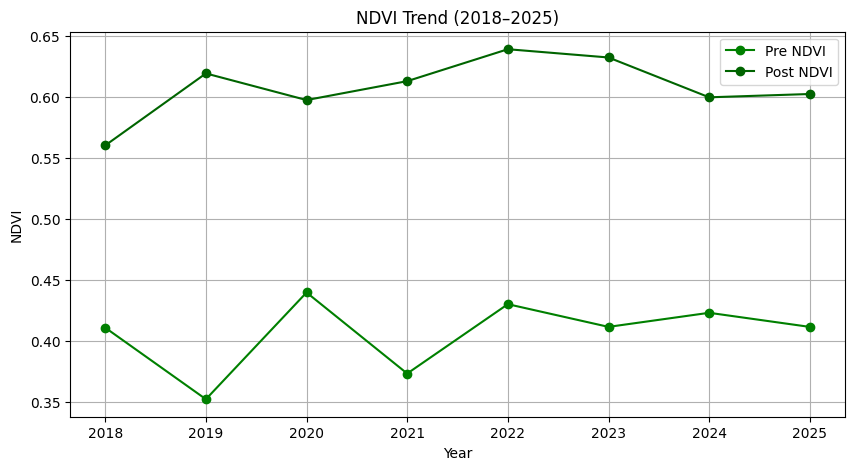

In [39]:
plt.figure(figsize=(10,5))

plt.plot(pre['year'], pre['NDVI'], marker='o', color='green', label='Pre NDVI')
plt.plot(post['year'], post['NDVI'], marker='o', color='darkgreen', label='Post NDVI')

plt.title("NDVI Trend (2018–2025)")
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.legend()
plt.grid(True)

plt.show()


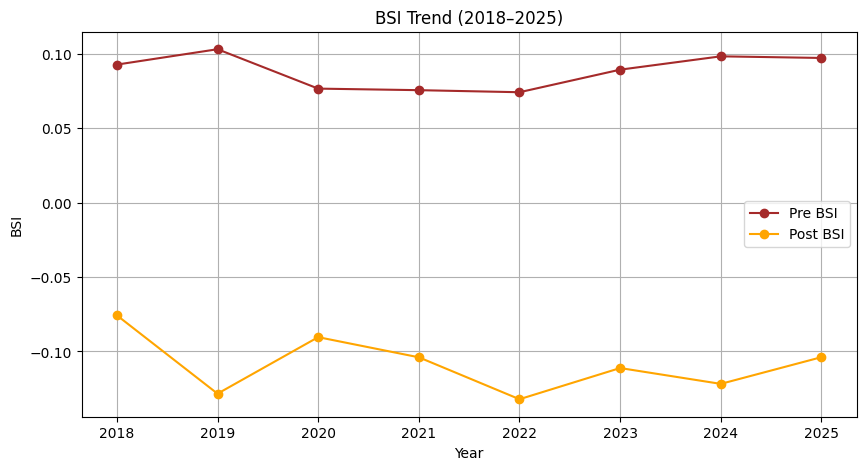

In [40]:
plt.figure(figsize=(10,5))

plt.plot(pre['year'], pre['BSI'], marker='o', color='brown', label='Pre BSI')
plt.plot(post['year'], post['BSI'], marker='o', color='orange', label='Post BSI')

plt.title("BSI Trend (2018–2025)")
plt.xlabel("Year")
plt.ylabel("BSI")
plt.legend()
plt.grid(True)

plt.show()


# Conclusion


In [ ]:
# Pre NDVI slope: +0.00394
# Post NDVI slope: +0.00390

# NDVI is slightly increasing over years.

In [ ]:
# Pre BSI slope: +0.00053
# Post BSI slope: -0.00303

# Interpretation:
#   - Pre-monsoon soil exposure slightly increasing (very small)
#   - Post-monsoon soil exposure decreasing

# That does NOT indicate large-scale degradation.

In [ ]:
# # Important Insight

#   Your ROI is large (~3500 sq km).
#   Mean NDVI averages everything:
#     Dense forest
#     Small degraded patches
#     Regrowth areas

#   Local degradation may exist, but mean hides it.

# Whole-ROI mean trend -------> Pixel-wise trend analysis.

In [41]:
ndvi_collection = []

for year in range(2018, 2026):

    img = add_indices(get_premonsoon(year)) \
        .select('NDVI') \
        .set('year', year)

    ndvi_collection.append(img)

ndvi_ic = ee.ImageCollection(ndvi_collection)


In [42]:
def add_time_band(image):
    year = ee.Number(image.get('year'))
    time_band = ee.Image.constant(year).rename('time').toFloat()
    return image.addBands(time_band)

ndvi_ic = ndvi_ic.map(add_time_band)


In [44]:
trend = ndvi_ic.select(['time', 'NDVI']) \
    .reduce(ee.Reducer.linearFit())

ndvi_slope = trend.select('scale')


In [45]:
Map.addLayer(
    ndvi_slope,
    {
        'min': -0.02,
        'max': 0.02,
        'palette': ['red', 'white', 'green']
    },
    "NDVI Trend (2018–2025)"
)

Map


Map(bottom=228493.0, center=[22.69448670430044, 82.78850555419923], controls=(WidgetControl(options=['position…

In [ ]:
# 🔴 Red → NDVI decreasing (possible degradation)

# ⚪ White → stable

# 🟢 Green → improving vegetation

In [ ]:
# Check If It’s Real or Noise

# Sometimes small red dots are:

# Sensor noise

# Seasonal variability

# Edge masking artifacts

# We must filter meaningful degradation.

In [47]:
# meaningful red pixels only
degraded = ndvi_slope.lt(-0.005)

Map.addLayer(
    degraded.updateMask(degraded),
    {'palette': ['red']},
    "Significant Degradation"
)

Map


Map(bottom=57234.0, center=[22.983681160330878, 83.93692038045623], controls=(WidgetControl(options=['position…

# Quantify Degraded Area

In [50]:
# Count degraded pixels
degraded_count = degraded.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e13,
    bestEffort=True,
    tileScale=4   # VERY IMPORTANT
)

count = ee.Number(degraded_count.get('scale'))
area_sqkm = count.multiply(30*30).divide(1e6)

print("Degraded Area (sq km):", area_sqkm.getInfo())

Degraded Area (sq km): 442.439745882353
